11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 367ms/step - loss: 0.1166 - val_loss: 0.1140
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 360ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 363ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 361ms/step - loss: 0.1123 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


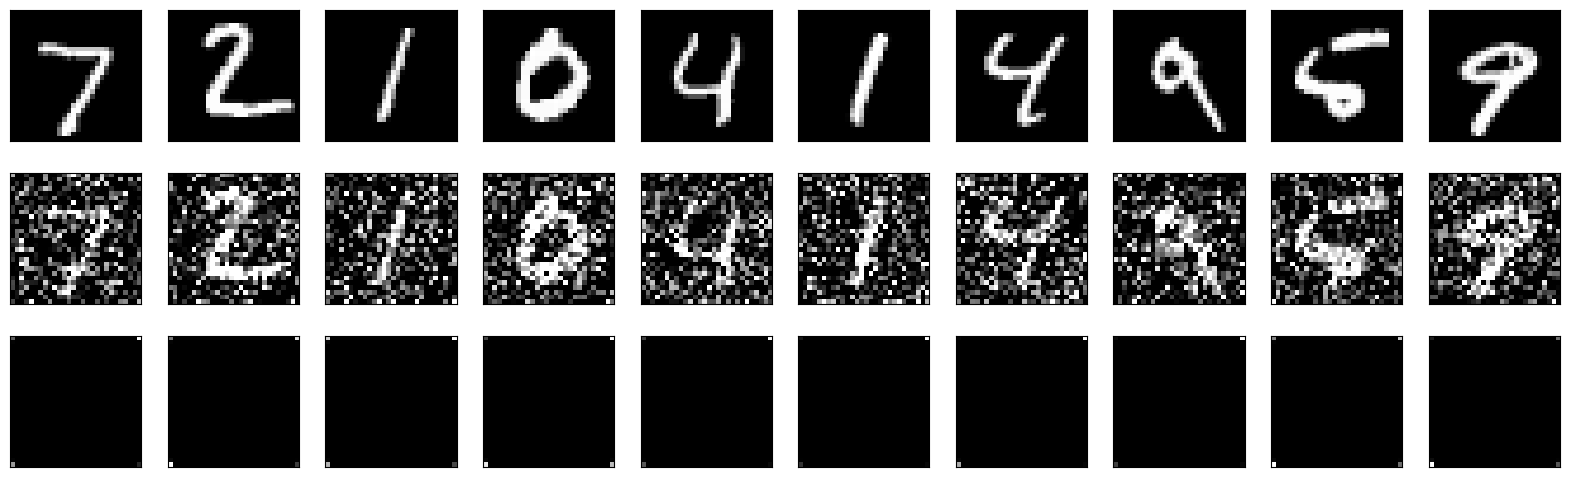

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()

# Normalize and reshape the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add artificial noise to the images
noise_factor = 0.5
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

# Clip the values to ensure they are within the valid range [0, 1]
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Define the Autoencoder model
def autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the Autoencoder model
    autoencoder_model = Model(input_img, decoded)
    return autoencoder_model

input_shape = (28, 28, 1)
model = autoencoder(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on the noisy images
model.fit(train_noisy.reshape(-1, 28, 28, 1), train_images.reshape(-1, 28, 28, 1),
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_data=(test_noisy.reshape(-1, 28, 28, 1), test_images.reshape(-1, 28, 28, 1)),
          callbacks=[early_stopping])

# Use the trained autoencoder to denoise the test images
denoised_images = model.predict(test_noisy.reshape(-1, 28, 28, 1))

# Display a few examples of original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(test_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()